In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from scipy.stats import skew

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline

In [17]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]

all_data = pd.concat((train.iloc[:, :-1], test.iloc[:, :-1]), sort=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16064dd8>,
      dtype=object)

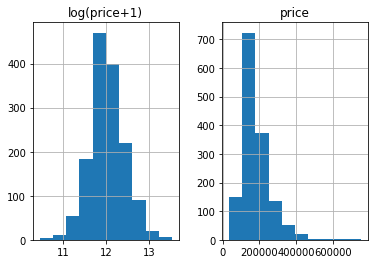

In [18]:
prices = pd.DataFrame({"price": train["SalePrice"], "log(price+1)": np.log1p(train["SalePrice"])})
prices.hist()

In [19]:
train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data

In [20]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [21]:
X_train = all_data[: train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

In [22]:
def rmse(model, X, y):
    return np.sqrt(np.mean(-cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error'))) 

In [23]:
lr = Ridge()

parameters = [{'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}]

grids = GridSearchCV(lr, param_grid=parameters, cv=5)
cls = grids.fit(X_train, y_train)
print('best parameters: ', cls.best_params_)
print('best results: ', np.sqrt(np.mean(-cross_val_score(cls.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))))

best parameters:  {'alpha': 10}
best results:  0.1283166433714929


In [24]:
rf = RandomForestRegressor()
parameters=[{'n_estimators': [10, 50, 100, 200, 300], 'min_samples_leaf': np.arange(1, 20, 5)}]

grids = GridSearchCV(rf, param_grid=parameters, cv=5)
# X_train.isna().sum()
cls = grids.fit(X_train, y_train)
print('best parameters: ', cls.best_params_)
print('best results: ', np.sqrt(np.mean(-cross_val_score(cls.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))))

best parameters:  {'min_samples_leaf': 1, 'n_estimators': 200}
best results:  0.14286009974776356


In [25]:
import xgboost as xgb

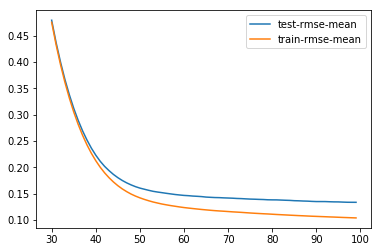

In [26]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth": 2, "eta": 0.1}
model = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=100)
model.loc[30:, ["test-rmse-mean", "train-rmse-mean"]].plot()



In [27]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)

print('best results: ', np.sqrt(np.mean(-cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))))

best results:  0.12527873076651616


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [29]:
lr = Ridge(alpha=10)
rf = RandomForestRegressor(n_estimators=200, max_depth=6)
xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1)

averaging_models = AveragingModels([lr, rf, xgb_model])
print('best results', rmse(averaging_models, X_train, y_train))

best results 0.12505081920642536


In [30]:
# averaging_models.fit(X_train, y_train)
# predicted_test = averaging_models.predict(X_test)

# my_submission = pd.DataFrame({'Id': test.index.values, 'SalePrice': np.exp(predicted_test)})
# my_submission.to_csv('submission.csv', index = False)